# Fewshot segmentation experiment 
J.Cristiano     
10/22/2024     

The purpose of this notebook is to use a few segmentations of brace root images to enhance segmentations of brace roots.    
I might also take a second look at the key difference between SAM2 and FSmedSAM2 (removal of 
object_score_logits) as well as consider the feasibility of Strictly One Shot Few Query technique.

In [1]:
!pip install pycocotools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.8/427.8 KB 9.1 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 46.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.9/106.9 KB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 54.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.0/322.0 KB 23.7 MB/s eta 0:00:00


In [2]:
import json
from pycocotools.coco import COCO
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [3]:
# coco = COCO('/work/7-8-24_annot.json')
coco = COCO('/work/2024_annotations.json')
# Get image IDs
img_ids = coco.getImgIds()
# Get the first image
img_id = img_ids[4] #select images at index 2,3,4
img_info = coco.loadImgs(img_id)[0]
# Get annotations for the image
ann_ids = coco.getAnnIds(imgIds=img_id)
anns = coco.loadAnns(ann_ids)

loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


In [4]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )



using device: cuda


In [5]:
import shutil
from sam2.build_sam import build_sam2
from sam2.build_sam import build_sam2_video_predictor

sam2_checkpoint = "/opt/sam2/checkpoints/sam2.1_hiera_tiny.pt"
# model_cfg = "configs/sam2.1/sam2.1_hiera_t.yaml"
shutil.copy("/work/no_pos_sam2.1_hiera_t.yaml", "/opt/sam2/sam2/configs/sam2.1/no_pos_sam2.1_hiera_t.yaml")
model_cfg = "configs/sam2.1/no_pos_sam2.1_hiera_t.yaml"

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device)
predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)

In [6]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

In [7]:
import os
import shutil
import tempfile
temp_dir = tempfile.mkdtemp()
for img_id in coco.getImgIds():
    img_info = coco.loadImgs(img_id)[0]
    file_name = img_info['file_name']
    image_id = img_info['id']
    
    # Construct the source and destination file paths
    src_path = os.path.join('/work/images/', file_name)
    dest_path = os.path.join(temp_dir, f"{image_id}.jpg")
    
    # Copy the file to the temporary directory with the new name
    shutil.copy(src_path, dest_path)

print(f"Images have been copied to the temporary directory: {temp_dir}")

Images have been copied to the temporary directory: /tmp/tmpmvk5n_3v


frame loading (JPEG): 100%|█████████████████████████████████████████████████████████████████| 107/107 [00:09<00:00, 10.76it/s]
/opt/sam2_env/lib/python3.10/site-packages/torch/nn/modules/linear.py:125: UserWarning: Attempting to use hipBLASLt on an unsupported architecture! Overriding blas backend to hipblas (Triggered internally at ../aten/src/ATen/Context.cpp:296.)
  return F.linear(input, self.weight, self.bias)
/opt/sam2/sam2/modeling/sam/transformer.py:270: UserWarning: Memory efficient kernel not used because: (Triggered internally at ../aten/src/ATen/native/transformers/hip/sdp_utils.cpp:779.)
  out = F.scaled_dot_product_attention(q, k, v, dropout_p=dropout_p)
/opt/sam2/sam2/modeling/sam/transformer.py:270: UserWarning: Memory Efficient attention has been runtime disabled. (Triggered internally at ../aten/src/ATen/native/transformers/sdp_utils_cpp.h:558.)
  out = F.scaled_dot_product_attention(q, k, v, dropout_p=dropout_p)
/opt/sam2/sam2/modeling/sam/transformer.py:270: UserWar

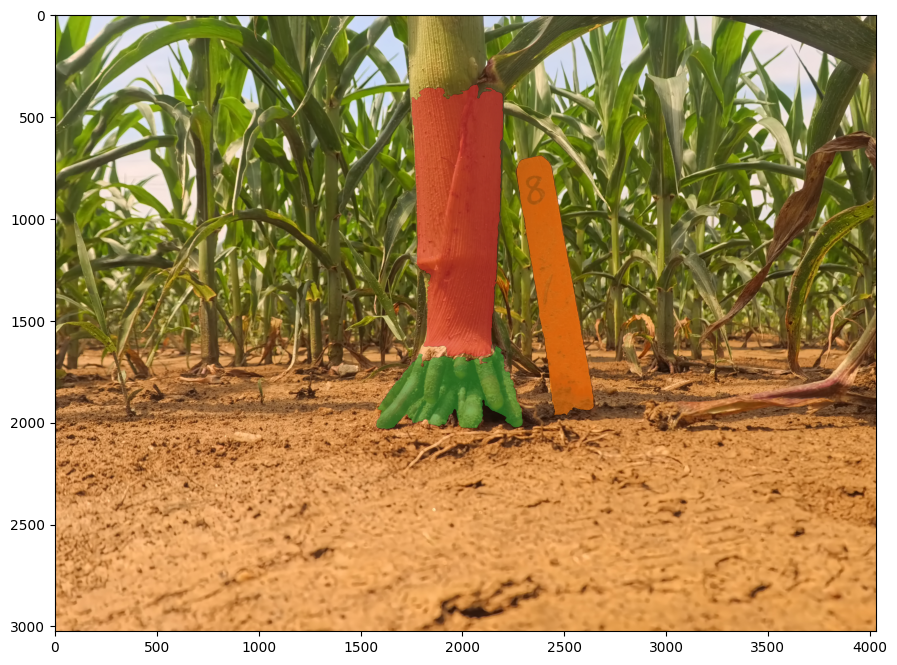

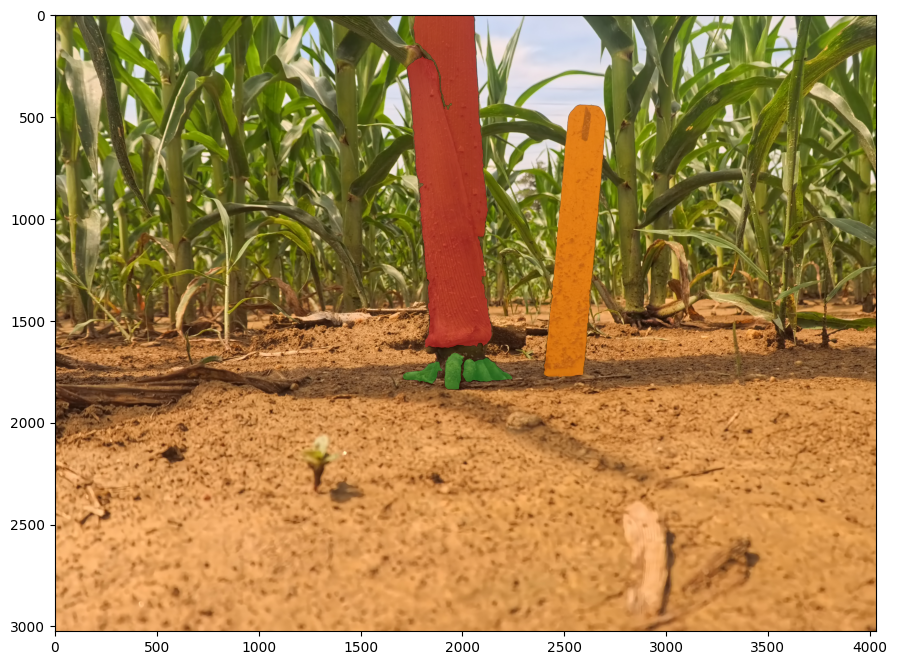

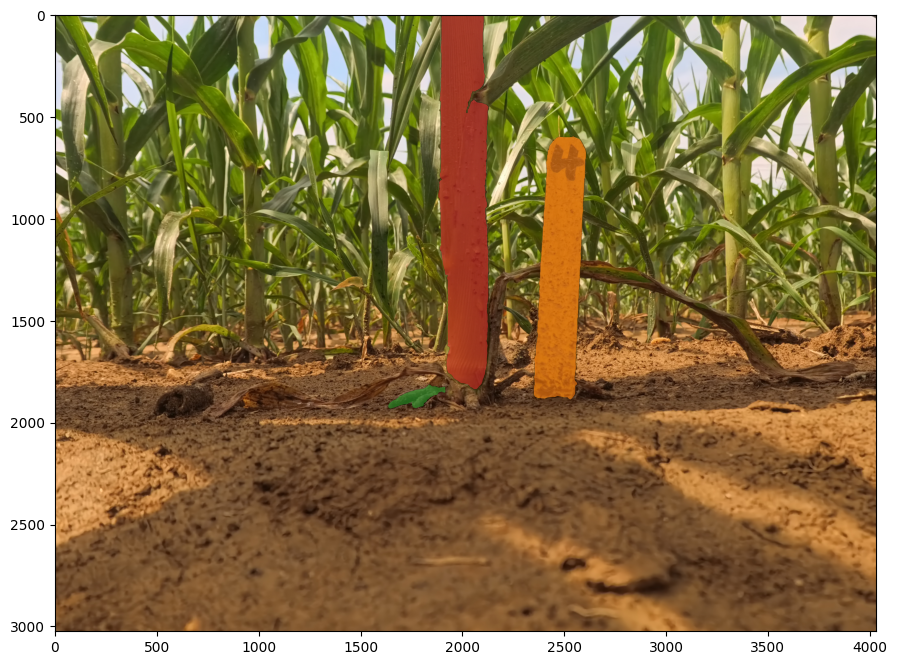

In [8]:
from matplotlib.image import imread
inference_state = predictor.init_state(video_path=temp_dir)

# Iterate over images and apply masks
for img_id in [img_ids[8], img_ids[10], img_ids[13]]:
    img_info = coco.loadImgs(img_id)[0]
    img = imread(temp_dir + '/' + str(img_id) + '.jpg')
    
    # Get annotations for the image
    ann_ids = coco.getAnnIds(imgIds=img_id)
    anns = coco.loadAnns(ann_ids)
    
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(img) 
    
    for ann in anns:
        mask = coco.annToMask(ann)
        frame_idx = img_id  # Assuming frame_idx is the same as img_id
        obj_id = ann['category_id']  # Assuming obj_id is the category_id
        
        # Add new mask using predictor
        _, out_obj_ids, out_mask_logits = predictor.add_new_mask(
            inference_state,  # Provide the appropriate inference state
            frame_idx,
            obj_id,
            mask,
        )
        
        # Show the mask
        show_mask(mask, ax, obj_id=obj_id)
    
    plt.show()

In [9]:
from PIL import Image
# run propagation throughout the video and collect the results in a dict
video_segments = {}  # video_segments contains the per-frame segmentation results
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }


propagate in video: 100%|█████████████████████████████████████████████████████████████████████| 98/98 [00:39<00:00,  2.49it/s]


: 

In [10]:
# frame_names = [f for f in os.listdir(temp_dir) if f.endswith('.jpg')]
# # Sort the list based on the numeric part of the filenames
# frame_names = sorted(frame_names, key=lambda x: int(x.split('.')[0]))
frame_names = list(video_segments.keys())
print(f"Number of frames: {frame_names}")
vis_frame_stride = 1
plt.close("all")
for out_frame_idx in frame_names[::vis_frame_stride]:
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}")
    plt.imshow(Image.open(os.path.join(temp_dir, str(out_frame_idx) + '.jpg')))
    if out_frame_idx not in video_segments:
        continue
    else:
        for out_obj_id, out_mask in video_segments[out_frame_idx].items():
            show_mask(out_mask, plt.gca(), obj_id=out_obj_id)

Number of frames: [9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106]


/tmp/ipykernel_2923/1559368946.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(6, 4))


: 

: 